In [9]:
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import math
import openpyxl
from statistics import * 

In [10]:
#User enters data here
file = 'GCData-JGI_ACRs w Conc Data.xlsx' #file name
sheet = 'Corrected Concentration' #sheet with corrected concentration data
samples = ['A10','A12', 'B12', 'C10','C11','C12','D10','E11','H9','H10','H12','MaACR','Neg','Rec'] #name of samples ### Do these have to be in order?
numVials = [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3] ### USER INPUT number of vials per sample in order of appearance 

# Check to see if lists samples and numVials are the same length
if len(samples) != len(numVials):
    raise Exception('Length of samples and numVials lists must be the same, hoe!')

chains = ['C4','C6', 'C8','C10','C12','C14','C16'] #chain lenghts
title = 'JGI ACR Homolog' #graph title
ylabel = 'mg/L FaOH' #y axis label



In [11]:
#this function arranges data into an appropriate matrix. correctedConc should be clean with no empty spaces
def dataArrange(correctedConc, numTotSamples):
    numChains = int(len(correctedConc)/numTotSamples)
    correctedConc = np.array(correctedConc)
    rearranged = np.zeros((numTotSamples, numChains))
    iterator = 0;
    for sample in range(0,numTotSamples):
        for chain in range(0, numChains):
            rearranged[sample, chain] = correctedConc[iterator]
            iterator = iterator + 1 
    return rearranged.T, rearranged.T.shape

In [12]:
#Calculates average and standard deviation of data
def calcStats(data):
    stats = [mean(data), stdev(data)]
    return stats

In [13]:
#Returns average and standard deviation data in the form of matricies
def dataParse(rearranged, samples, numVials):
    #rearranged - the rearranged corrected concentration data table with each row corresponding to a chain length
        #and each column corresponding to a sample vial i.e.
        #
        #         H204A-1  H204A-2  H204A-3    WT-1    WT-2    WT-3
        #   C8 [[    #        #        #        #        #        #    ],
        #  C10  [    #        #        #        #        #        #    ],
        #  C12  [    #        #        #        #        #        #    ],
        #  C14  [    #        #        #        #        #        #    ],
        #  C16  [    #        #        #        #        #        #    ]]
        #
    #samples - list of each type of sample i.e. [H204A, WT]
    #numVials - number of vials per sample in order of appearance i.e. [3, 3]
    
    numChains = int(len(rearranged[0])) #number of chain lengths testing for
    avgMat = np.zeros((numChains, len(samples))) #matrix to store average data
    stdevMat = np.zeros((numChains, len(samples))) #matrix to store stdev data

    row_number = range(0,len(chains))
    column_number = range(0,len(samples))

    for r in row_number:
        #print(rearranged[0][r])
        for c in column_number:
            avgMat[r,c] = np.mean(rearranged[0][r][c*3:(c*3)+2]) # rearranged is an array which is set up such that each row contains the concentration for a given chain length for all samples
            stdevMat[r,c] = np.std(rearranged[0][r][c*3:(c*3)+2])
        
    return avgMat,stdevMat

In [14]:
#Creates stacked bar chart of chain length distributions
def createBarChart (file, sheet, samples, numVials, chains, title, ylabel):
    #get concentration data from excel sheet
    concData = getCorrectedConcentration(file,sheet)
    #arrange data into more managable rows and columns
    rearranged = dataArrange(concData, sum(numVials))
    
    #get mean and standard deviation data
    avgMat, stdevMat = dataParse(rearranged, samples, numVials)
    df_avg = pd.DataFrame(avgMat, columns=samples)
    df_std = pd.DataFrame(stdevMat, columns=samples)

    #plot data
    %matplotlib inline
    N = len(samples)
    ind = np.arange(N)
    width = 0.35
    firstMean = df_avg.loc[0,:]
    firstStd = df_std.loc[0,:]
    fistplot = plt.bar(ind, firstMean, width, yerr=firstStd, label=chains[0])
    sumMeans = [0]*len(samples)
    for chain in range(1,len(chains)):
        chainMean = df_avg.loc[chain,:]
        prevChainMean = df_avg.loc[chain-1,:]
        for i in range(len(sumMeans)):
            sumMeans[i] = sumMeans[i] + prevChainMean[i]
        chainStd = df_std.loc[chain,:]
        plt.bar(ind, chainMean, width, bottom=sumMeans, yerr=chainStd, label=chains[chain])
    plt.xticks(ind,samples)
    plt.legend()
    plt.suptitle(title)
    plt.ylabel(ylabel)
    plt.show

In [15]:
#returns clean list of corrected concentrations from an excel file
def getCorrectedConcentration (file, sheet):
    wb = openpyxl.load_workbook(file)
    df = pd.read_excel(file, sheet_name=sheet)
    print(df)
    correctedConc = []
    for i in df.index:
        conc = df['Corrected Concentration'][i]
        if isinstance(conc, float) and not math.isnan(conc): #math.isnan returns True if conc is nan
            correctedConc.append(conc)
            
            print(correctedConc)
    return correctedConc

          0       1       2         3        4        5  \
0     A10-1   A10-1   A10-1     A10-1    A10-1    A10-1   
1     Peak#  R.time  I.time    F.Time     Area  Peak_ID   
2     3.495   3.451   3.579      1478      431       C3   
3       NaN     NaN     NaN       NaN    1e-09       C4   
4    12.099  11.987  12.107  28972122  4235909       C5   
..      ...     ...     ...       ...      ...      ...   
709  22.281  22.191  22.548    144566    59901      C13   
710  23.112  23.016  23.324    146437    63535      C14   
711  23.909  23.823  24.127    144804    64730      C15   
712  24.676  24.592  24.791    139305    64672      C16   
713  25.415  25.352  25.515    157400    75290      C17   

     Uncorrected Concentration  Scaling Factor  Averaged Scaling Factor  \
0                 0.000000e+00             NaN                      NaN   
1                 0.000000e+00             NaN                      NaN   
2                 1.127884e+00        0.022558                    

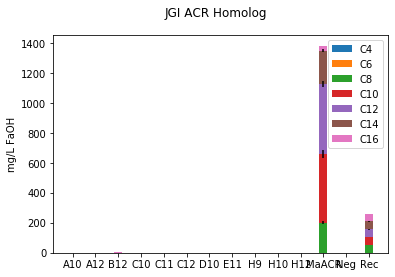

In [16]:
createBarChart(file, sheet, samples, numVials, chains, title, ylabel)

In [358]:
rearranged[0]

array([[   1.67049171,    1.53894258,    4.15420045,  112.83577184,
         107.19640796,  110.67282071,   15.85106094,   23.61141136,
          25.50998567,    9.11570333,    8.83495209,    9.2003191 ],
       [   0.84959623,    0.84954965,    0.87813229,   20.59594407,
          15.58935111,   18.81021535,    6.71367671,   13.21366716,
          13.18094301,    8.57661202,    8.62765435,    9.22487511],
       [   1.39151337,    1.24843537,    1.68249437,  106.68924054,
          71.63576289,   91.55541314,  350.54535531,  358.31358574,
         323.67174791,  430.39610461,  412.98248274,  432.88707739],
       [   2.57723174,    0.        ,    2.16589698,  119.98241821,
          75.29643629,  100.052131  ,   19.87433762,    0.52410207,
         339.52465146,   23.91321352,    3.68128396,   21.61274348],
       [   6.94144444,    7.48636412,   12.58737466,   22.06740554,
          19.1557307 ,   33.27648634,    7.92029316,    5.01143647,
           4.21639661,    3.54451291,    2.6